In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import cyipopt as ipopt
import matplotlib.pyplot as plt

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    #calculation of portfolio value
    portfolio_V = np.dot(cur_prices, x_init) + cash_init
    #equal weight for the 20 stocks
    w = np.ones((20)) / 20      
    #equal allocation of money for each asset 
    each_asset_V = w * portfolio_V 
    #rounding procedure of number of shares  
    x_optimal = np.floor(each_asset_V / cur_prices)  
    tran_cost = np.dot(cur_prices, abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_V - np.dot(cur_prices, x_optimal) - tran_cost  
    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    #calculation of portfolio value
    portfolio_V = np.dot(cur_prices, x_init) + cash_init
    cpx = cplex.Cplex()  
    #set sense to minimize objective
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = np.zeros((20))
    lb = np.zeros((20))
    ub = np.ones((20))
    A = []
    for i in range(20):
        A.append([[0,1],[1,0]]) 
    var_names = ['w_%s'% i for i in range(1,21)]
    #add objective function, bounds on variables and constraint to cplex model
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EG')   
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)
    #define and add quadratic part of objective function
    Qmat = [[list(range(20)),list(2*Q[k,:])] for k in range(20)] 
    cpx.objective.set_quadratic(Qmat)   
    alg = cpx.parameters.lpmethod.values  
    cpx.parameters.qpmethod.set(alg.concurrent) 
    #disable the print of results and warnings
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    #optimize the problem
    cpx.solve()
    #optimal weights
    w = np.array(cpx.solution.get_values()) 
    each_asset_V = w * portfolio_V
    #rounding procedure of number of shares   
    x_optimal = np.floor(each_asset_V / cur_prices) 
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_V - np.dot(cur_prices,x_optimal) - tran_cost 
    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    #calculation of portfolio value
    portfolio_V = cur_prices.dot(x_init) + cash_init
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    daily_rf = r_rf / 252
    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q2 = np.vstack([Q1,np.zeros((21))])  
    SR_diff = mu-daily_rf * np.ones(20) 
    cpx = cplex.Cplex()  
    #set sense to minimize objective
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = [0]*21
    lb = [0]*21
    ub = [np.inf]*21
    A = []
    for i in range(20):
        A.append([[0,1],[SR_diff[i],1.0]])
    A.append([[0,1],[0,-1.0]]) 
    var_names = ['y_%s'% i for i in range(1,22)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE') 
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)
    Qmat = [[list(range(21)),list(2*Q2[k,:])] for k in range(21)]
    #set quadratic objective
    cpx.objective.set_quadratic(Qmat)
    alg = cpx.parameters.lpmethod.values  
    cpx.parameters.qpmethod.set(alg.concurrent) 
    #disable the print of results and warnings
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    #optimize the problem
    cpx.solve()
    if cpx.solution.get_status_string()== 'infeasible':
      x_optimal = x_init
      cash_optimal = cash_init
      w_maxSharp = (x_init*cur_prices)/portfolio_V
    else:
      w = np.array(cpx.solution.get_values())
      w = w[0:20]/w[20]
      each_asset_V = w * portfolio_V   
      #rounding procedure of number of shares
      x_optimal = np.floor(each_asset_V / cur_prices)  
      tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
      cash_optimal = portfolio_V - np.dot(cur_prices,x_optimal) - tran_cost 
    return x_optimal, cash_optimal

# Define objective function, constraints, gradient of objective fucntion, and jacobian of constrants for the "Equally Risk Contribution" part

In [3]:
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(20):
            for j in range(i,20):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(20)
        # Use finite differences to check gradient
        y = x * np.dot(Q,x)
        for i in range(20):
            for j in range(i,20):
                diff1 = Q[i].dot(x) + Q[i,i] * x[i]
                diff2 = Q[i,j] * x[i]
                g = (y[i]-y[j]) * (diff1 - diff2)
                grad[i] = grad[i] + g
            grad[i] = 4 *  grad[i]
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * 20
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * 20])

# "Equal Risk Contributions"

In [4]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    #calculation of portfolio value
    portfolio_V = np.dot(cur_prices, x_init) + cash_init
    
    w0 = [1/20] * 20

    lb = [0] * 20
    ub = [1] * 20
    cl = [1]
    cu = [1]
    #define the IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    #set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)

    #solve the problem
    w_erc, info = nlp.solve(w0)
    #compute variance and asset risk contributions for the ERC portfolio
    vae_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC= np.sqrt(np.dot(w_erc, np.dot(Q, w_erc)))
    RC_ERC = (w_erc* np.dot(Q, w_erc)) / std_ERC
    
    each_asset_V = w_erc * portfolio_V
    #rounding procedure of number of shares
    x_optimal = np.floor(each_asset_V / cur_prices) 
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_V - np.dot(cur_prices, x_optimal) - tran_cost  
    return x_optimal, cash_optimal

# "Leveraged equal risk contributions"

In [5]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    #risk-free rate
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    #calculation of portfolio value
    portfolio_V = np.dot(cur_prices, x_init) + cash_init
    
    short_amount = init_value
    interest = init_value*(r_rf/6)
    if period == 1: # take long 200% position in first period
        portfolio_V = portfolio_V + short_amount
    
    w0 = [1/20] * 20

    lb = [0] * 20
    ub = [1] * 20
    cl = [1]
    cu = [1]
    #define the IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    #set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)

    #solve the problem
    w_lerc, info = nlp.solve(w0)
    w_lerc = np.array(w_lerc)
    w_lerc = w_lerc*(1/w_lerc.sum())
    each_asset_V = w_lerc * portfolio_V
    #rounding procedure of number of shares
    x_optimal = np.floor(each_asset_V / cur_prices) 
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_V - np.dot(cur_prices, x_optimal) - tran_cost - interest 
    return x_optimal, cash_optimal

# "Robust mean-variance optimization"

In [6]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    
    interest = 0
    #calculation of portfolio value
    portfolio_V = np.dot(cur_prices, x_init) + cash_init
    
    w0 = [1/20]*20
    ret_init = np.dot(mu, w0)
    var_init = np.dot(w0, np.dot(Q, w0))
    
    var_matr = np.diag(np.diag(Q))
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    rob_bnd = rob_init
    
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    #calculate daily risk-free rate
    daily_r_rf = r_rf/252
    
    Portf_Retn = daily_r_rf
    
    c = [0.0] * 20
    lb = [0.0] * 20
    ub = [1.0] * 20
    A = []
    for k in range(20):
        A.append([[0,1],[1.0,mu[k]]])
        
    cpx = cplex.Cplex()
    #set sense to minimize objective
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    var_names = ["w_%s" % i for i in range(1,21)]
    cpx.variables.add(obj=c,lb=lb, ub=ub, columns=A,names=var_names)
    Qmat = [[list(range(20)), list(2*Q[k,:])] for k in range(20)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(20), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    #setting number of threads to 4
    cpx.parameters.threads.set(4)
    #setting timelimit to 60
    cpx.parameters.timelimit.set(60)
    #setting Barrier algorithm convergence tolerance to 1e-12
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    #disable the print of results and warnings
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    if cpx.solution.get_status_string()== 'infeasible':
            x_optimal = x_init
            cash_optimal = cash_init
            
    else:
        w_rMV = np.array(cpx.solution.get_values())
        w_rMV[w_rMV<1e-6] = 0 
        w_rMV = w_rMV / np.sum(w_rMV)
        each_asset_V = w_rMV * portfolio_V
        #rounding procedure of number of shares  
        x_optimal = np.floor(each_asset_V / cur_prices)  
        tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
        cash_optimal = portfolio_V - np.dot(cur_prices,x_optimal) - tran_cost - interest
    
    return x_optimal, cash_optimal

In [7]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if cash[strategy, period-1] < 0:
          # if using leveraged equal risk contributions strategy
          if cash[5,0]<0:
              portfolio_V = (np.dot(cur_prices,curr_positions) + curr_cash) * 2
          else:
              portfolio_V = np.dot(cur_prices,curr_positions) + curr_cash
                
          ratio = x[strategy, period-1]/sum(x[strategy, period-1])
          neg_cash = abs(cash[strategy][period-1])*ratio
          neg_position = np.ceil(neg_cash/cur_prices)
          x[strategy][period-1] = x[strategy][period-1] - neg_position
          new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
          cash[strategy, period-1] = portfolio_V - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost
            
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      #if using leveraged equal risk contributions strategy
      if strategy ==5: 
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 1000013.0


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000013.00, value end = $ 893956.82
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.24, value end = $ 893208.59
  Strategy "Mininum Variance Portfolio", value begin = $ 992742.15, value end = $ 916346.31
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.37, value end = $ 922095.98

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in ine

  16  9.9885737e-11 0.00e+00 7.90e-10 -11.0 7.73e-04    -  1.00e+00 1.00e+00f  1
  17  8.1253162e-11 0.00e+00 6.32e-10 -11.0 1.51e-03    -  1.00e+00 1.00e+00f  1
  18  3.3734690e-11 0.00e+00 2.75e-09 -11.0 7.42e-03    -  1.00e+00 1.00e+00f  1
  19  2.5171432e-11 0.00e+00 1.07e-09 -11.0 2.88e-02    -  1.00e+00 1.25e-01f  4
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 883037.33, value end = $ 711803.47

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   2.5171431802488956e-11    2.5171431802488956e-11
Dual infeasibility......:   1.0671088974095238e-09    1.0671088974095238e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.2108500196109260e-11    1.2108500196109260e-11
Overall NLP error.......:   1.0671088974095238e-09    1.0671088974095238e-09




  16  1.4101684e-08 0.00e+00 8.98e-08 -11.0 1.57e-03    -  1.00e+00 1.00e+00f  1
  17  4.0962734e-09 0.00e+00 8.90e-07 -11.0 1.50e-02    -  1.00e+00 1.00e+00f  1
  18  4.0962734e-09 0.00e+00 8.90e-07 -11.0 4.68e-02    -  1.00e+00 8.88e-16f 51
  19  4.0962734e-09 0.00e+00 8.90e-07 -11.0 4.68e-02    -  1.00e+00 1.11e-16f 54
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.0962734e-09 0.00e+00 8.90e-07 -11.0 4.67e-02    -  1.00e+00 1.11e-16f 54
  21  4.0943267e-09 0.00e+00 8.89e-07 -11.0 8.90e-07    -  1.00e+00 1.00e+00f  1
  22  1.5905809e-09 0.00e+00 7.18e-08 -11.0 2.21e-03    -  1.00e+00 1.00e+00f  1
  23  1.3996379e-09 0.00e+00 6.78e-08 -11.0 1.81e-04    -  1.00e+00 1.00e+00f  1
  24  4.9005268e-10 0.00e+00 6.22e-08 -11.0 1.41e-03    -  1.00e+00 1.00e+00f  1
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 651039.78, value end = $ 841133.19

Number of Iterations....: 24

                                   (scaled)      

  18  1.6249099e-10 0.00e+00 5.96e-09 -11.0 2.45e-03    -  1.00e+00 1.00e+00f  1
  19  1.4061423e-10 0.00e+00 3.27e-09 -11.0 1.16e-03    -  1.00e+00 1.00e+00f  1
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 833629.85, value end = $ 1113373.78

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   1.4061422771839477e-10    1.4061422771839477e-10
Dual infeasibility......:   3.2730772365624274e-09    3.2730772365624274e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.9999999940145415e-12    9.9999999940145415e-12
Overall NLP error.......:   3.2730772365624274e-09    3.2730772365624274e-09


Number of objective function evaluations             = 30
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations    

  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1129381.60, value end = $ 996902.32
  18  6.3208127e-11 0.00e+00 3.74e-10 -11.0 3.77e-03    -  1.00e+00 1.00e+00f  1
  19  5.6679642e-11 0.00e+00 9.14e-10 -11.0 4.76e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   5.6679642342419245e-11    5.6679642342419245e-11
Dual infeasibility......:   9.1381657067911267e-10    9.1381657067911267e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.9999999968989801e-12    9.9999999968989801e-12
Overall NLP error.......:   9.1381657067911267e-10    9.1381657067911267e-10


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations    

Number o  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1013321.99, value end = $ 1368981.97f Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.095

EXIT: Solved To Acceptable Level.

  Strategy "Robust Optimization Portfolio", value begin = $ 1104505.48, value end = $ 1239405.79

Period 7: start date 01/04/2021, end date 02/26/2021
  Strategy "Buy and Hold", value begin = $ 1005601.39, value end = $ 956244.08
  Strategy "Equally Weighted Portfolio", value begin = $ 1180783.14, value end = $ 1267218.28
  Strategy "Mininum Variance Portfolio", value begin = $ 1003958.50, value end = $ 975058.02
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1737569.08, value end = $ 1851392.00
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in

  Strategy "Robust Optimization Portfolio", value begin = $ 1226078.78, value end = $ 1223422.86

Period 8: start date 03/01/2021, end date 04/30/2021
  Strategy "Buy and Hold", value begin = $ 957791.35, value end = $ 1019731.32
  Strategy "Equally Weighted Portfolio", value begin = $ 1297587.56, value end = $ 1398874.11
  Strategy "Mininum Variance Portfolio", value begin = $ 975374.12, value end = $ 1088019.87
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1899769.93, value end = $ 2059602.42
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variable

  Strategy "Mininum Variance Portfolio", value begin = $ 1087822.50, value end = $ 1076739.48
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 2051066.72, value end = $ 2014754.84
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints w

  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 2013665.31, value end = $ 2121761.08
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) al

   7  8.4287542e-10 0.00e+00 2.88e-09 -10.7 1.22e-02    -  1.00e+00 1.00e+00f  1
   8  4.8163756e-10 0.00e+00 2.09e-09 -11.0 9.34e-03    -  1.00e+00 1.00e+00f  1
   9  2.6456049e-10 0.00e+00 1.86e-09 -11.0 1.17e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7430052e-10 0.00e+00 4.63e-09 -11.0 1.29e-02    -  1.00e+00 1.00e+00f  1
  11  1.2695396e-10 0.00e+00 9.13e-10 -11.0 1.04e-02    -  1.00e+00 1.00e+00f  1
  12  1.1231472e-10 0.00e+00 5.11e-10 -11.0 3.98e-03    -  1.00e+00 1.00e+00f  1
  13  9.3199345e-11 0.00e+00 3.88e-10 -11.0 5.05e-03    -  1.00e+00 1.00e+00f  1
  14  7.0166609e-11 0.00e+00 1.17e-09 -11.0 1.29e-02    -  1.00e+00 1.00e+00f  1
  15  6.0344503e-11 0.00e+00 4.50e-10 -11.0 3.80e-03    -  1.00e+00 1.00e+00f  1
  16  5.9541799e-11 0.00e+00 1.57e-10 -11.0 2.20e-03    -  1.00e+00 1.00e+00f  1
  17  5.6441625e-11 0.00e+00 1.20e-10 -11.0 1.84e-03    -  1.00e+00 1.00e+00f  1
  18  4.6753277e-11 0.00e+00

  13  5.3948206e-11 0.00e+00 4.61e-10 -11.0 2.49e-03    -  1.00e+00 1.00e+00f  1
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1470574.07, value end = $ 1523942.96
  14  4.4720956e-11 0.00e+00 4.67e-10 -11.0 2.24e-03    -  1.00e+00 1.00e+00f  1
  15  3.6817728e-11 0.00e+00 1.81e-10 -11.0 2.36e-03    -  1.00e+00 1.00e+00f  1
  16  2.2651334e-11 0.00e+00 7.76e-10 -11.0 5.22e-03    -  1.00e+00 1.00e+00f  1
  17  1.4802554e-11 0.00e+00 7.03e-10 -11.0 3.24e-03    -  1.00e+00 1.00e+00f  1
  18  6.0914285e-12 0.00e+00 9.34e-10 -11.0 5.94e-03    -  1.00e+00 1.00e+00f  1
  19  3.7153756e-12 0.00e+00 4.41e-10 -11.0 1.34e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   3.7153755539933515e-12    3.7153755539933515e-12
Dual infeasibility......:   4.4089797804394977e-10    4.4089797804394977e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+0

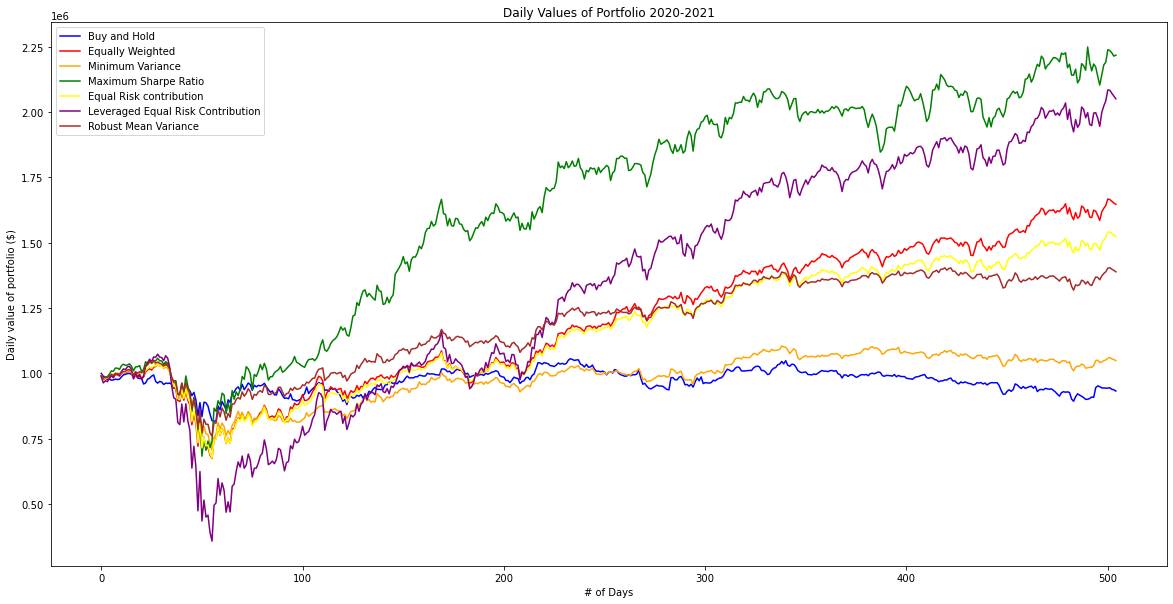

In [8]:
#Plot the daily value of the portfolio (for each trading strategy) over the years 2020 and 2021
plt.figure(figsize=(20,10))
plt.plot(portf_value[0], label='Buy and Hold', color='blue')
plt.plot(portf_value[1], label='Equally Weighted', color='red')
plt.plot(portf_value[2], label='Minimum Variance', color='orange')
plt.plot(portf_value[3], label='Maximum Sharpe Ratio', color='green')
plt.plot(portf_value[4],label='Equal Risk contribution', color = 'yellow')
plt.plot(portf_value[5],label='Leveraged Equal Risk Contribution', color = 'purple')
plt.plot(portf_value[6],label='Robust Mean Variance', color = 'brown')
plt.title('Daily Values of Portfolio 2020-2021')
plt.xlabel('# of Days')
plt.ylabel('Daily value of portfolio ($)')
plt.legend()
plt.show()


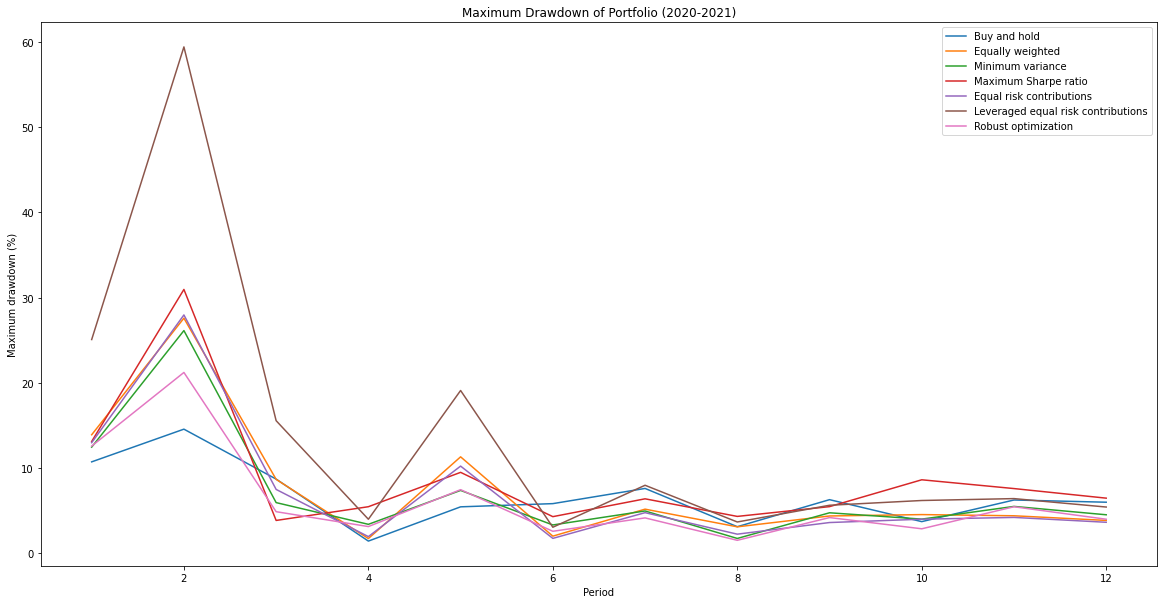

In [9]:
#Plot one chart in Python that illustrates maximum drawdown of your portfolio for each of the 12 periods
dfValues = pd.DataFrame()
for i in range(7):
    dfValues[str(i+1)] = portf_value[i].flatten()

dfList = []
indexArray = [[0,40],[41,82],[83,124],[125,167],[168,211],[212,252],[253,291],[292,334],[335,376],[377,419],[420,462],[463,504]]
for i in range(12):
    dfList.append(dfValues.loc[indexArray[i][0]:indexArray[i][1]])

maxDD_array = []
for i in range(12):
    periodArray = []
    for j in range(7):
        dfBuffer = ((dfList[i][str(j+1)] - dfList[i][str(j+1)].expanding().max()) / dfList[i][str(j+1)].expanding().max())*100
        dfBuffer = dfBuffer.abs()
        bufferVal = dfBuffer.max()
        periodArray.append(bufferVal)
    maxDD_array.append(periodArray)
    
dfMaxDD = pd.DataFrame()
for i in range(12):
    dfMaxDD[i+1] = maxDD_array[i] 
dfMaxDD = dfMaxDD.transpose()
dfMaxDD = dfMaxDD.rename(columns={0: "Buy and hold", 1: "Equally weighted", 2: "Minimum variance", 3: "Maximum Sharpe ratio", 4: "Equal risk contributions", 5: "Leveraged equal risk contributions", 6: "Robust optimization"})

dfMaxDD.plot(figsize=(20,10))
plt.title('Maximum Drawdown of Portfolio (2020-2021)')
plt.xlabel('Period')
plt.ylabel('Maximum drawdown (%)')
plt.show()

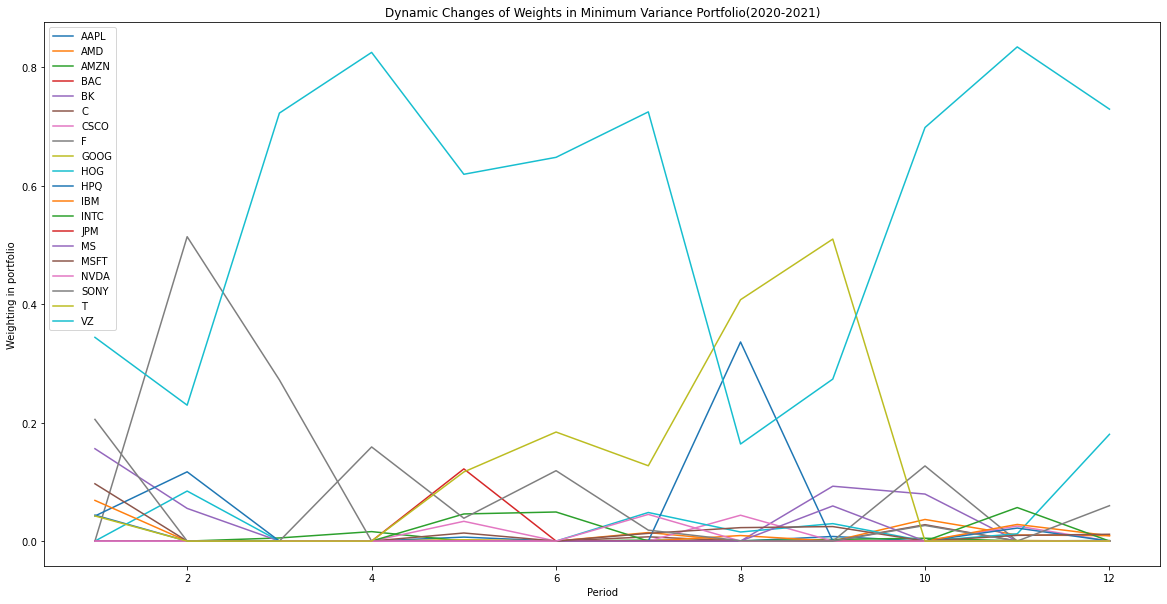

In [10]:
# Plot dynamic changes in portfolio allocations for strategy 3 Minimize Variance 
stocks = df.columns[1:]
w = []
for period in range(1, N_periods+1):
    w.append(x[2, period-1]/sum(x[2, period-1]))
df_minVar = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_minVar.plot(figsize=(20,10))
plt.title('Dynamic Changes of Weights in Minimum Variance Portfolio(2020-2021)')
plt.xlabel('Period')
plt.ylabel('Weighting in portfolio')
plt.show()

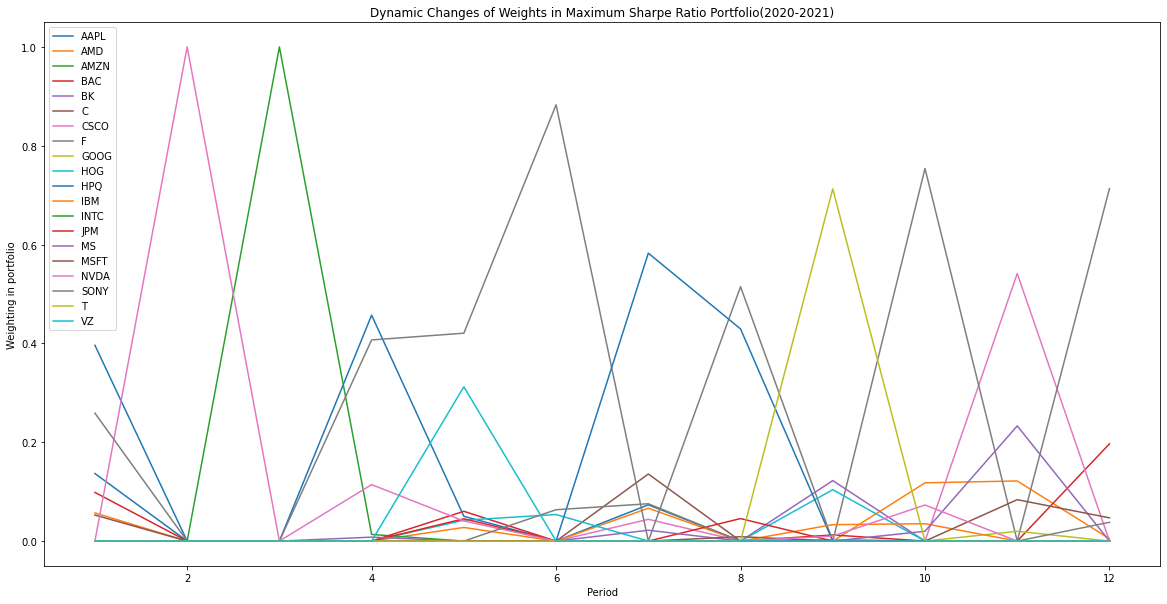

In [11]:
#Plot dynamic Changes in portfolio allocations for strategy 4 Maximize Sharpe Ratio 
stocks = df.columns[1:]
w = []
for period in range(1, N_periods+1):
    w.append(x[3, period-1]/sum(x[3, period-1]))
df_maxSR = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_maxSR.plot(figsize=(20,10))
plt.title('Dynamic Changes of Weights in Maximum Sharpe Ratio Portfolio(2020-2021)')
plt.xlabel('Period')
plt.ylabel('Weighting in portfolio')
plt.show()

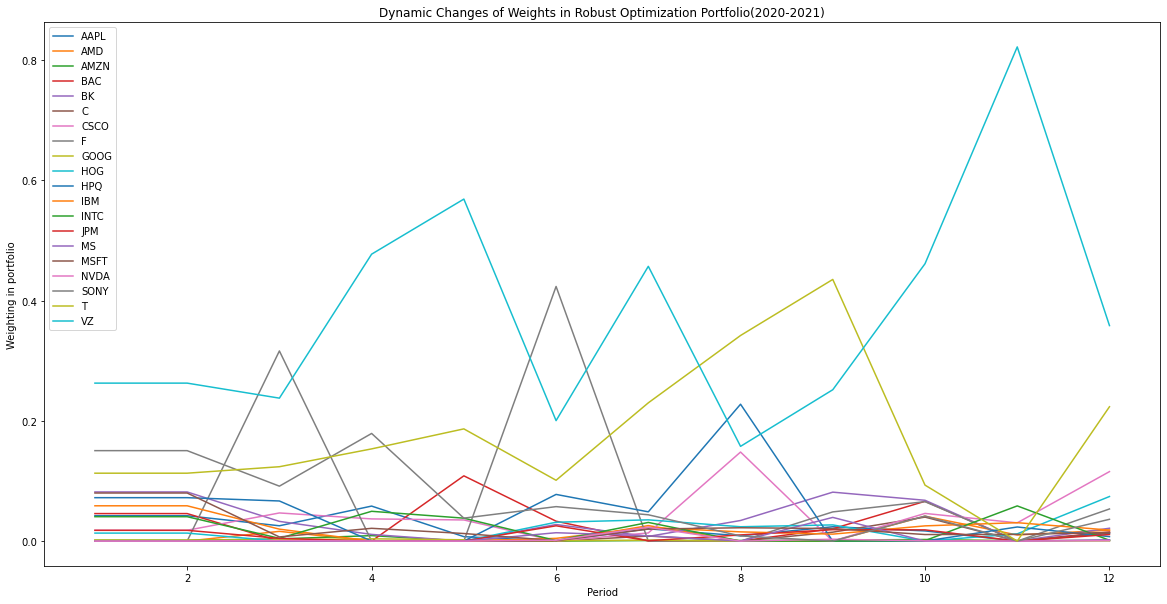

In [12]:
# Plot dynamic changes in portfolio allocations under strategy 7 Robust mean-variance optimization
stocks = df.columns[1:]
w = []
for period in range(1, N_periods+1):
    w.append(x[6, period-1]/sum(x[6, period-1]))
df_minVar = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_minVar.plot(figsize=(20,10))
plt.title('Dynamic Changes of Weights in Robust Optimization Portfolio(2020-2021)')
plt.xlabel('Period')
plt.ylabel('Weighting in portfolio')
plt.show()

# Test your trading strategies for years 2008 and 2009

In [13]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 8:
       cur_year  = 8 + math.floor(period/7)
   else:
       cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if cash[strategy, period-1] < 0:
          # if using leveraged equal risk contributions strategy
          if cash[5,0]<0:
              portfolio_V = (np.dot(cur_prices,curr_positions) + curr_cash) * 2
          else:
              portfolio_V = np.dot(cur_prices,curr_positions) + curr_cash
                
          ratio = x[strategy, period-1]/sum(x[strategy, period-1])
          neg_cash = abs(cash[strategy][period-1])*ratio
          neg_position = np.ceil(neg_cash/cur_prices)
          x[strategy][period-1] = x[strategy][period-1] - neg_position
          new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
          cash[strategy, period-1] = portfolio_V - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost
            
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      #if using leveraged equal risk contributions strategy
      if strategy ==5: 
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 385097.15


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 385097.15, value end = $ 325918.34
  Strategy "Equally Weighted Portfolio", value begin = $ 381649.89, value end = $ 326929.57
  Strategy "Mininum Variance Portfolio", value begin = $ 383262.32, value end = $ 327133.76
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 381265.54, value end = $ 332652.59
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality con

  Strategy "Mininum Variance Portfolio", value begin = $ 322708.14, value end = $ 365544.42
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 325785.77, value end = $ 344234.61
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with 

   8  5.8798382e-09 0.00e+00 6.43e-08 -11.0 1.02e-02    -  1.00e+00 1.00e+00f  1
   9  2.2212023e-09 0.00e+00 6.61e-08 -11.0 1.59e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3587371e-09 0.00e+00 6.50e-08 -11.0 2.14e-02    -  1.00e+00 5.00e-01f  2
  11  7.1733158e-10 0.00e+00 1.59e-08 -11.0 2.53e-03    -  1.00e+00 1.00e+00f  1
  12  4.4837956e-10 0.00e+00 1.38e-08 -11.0 2.04e-03    -  1.00e+00 1.00e+00f  1
  13  2.1264256e-10 0.00e+00 1.62e-08 -11.0 3.65e-03    -  1.00e+00 1.00e+00f  1
  14  2.0919281e-10 0.00e+00 2.52e-08 -11.0 6.95e-03    -  1.00e+00 1.00e+00f  1
  15  1.2440732e-10 0.00e+00 4.85e-08 -11.0 2.73e-03    -  1.00e+00 1.00e+00f  1
  16  9.8238202e-11 0.00e+00 1.75e-08 -11.0 2.07e-03    -  1.00e+00 1.00e+00f  1
  17  4.7871029e-11 0.00e+00 4.54e-09 -11.0 1.27e-03    -  1.00e+00 1.00e+00f  1
  18  3.6922609e-11 0.00e+00 1.87e-09 -11.0 3.55e-04    -  1.00e+00 1.00e+00f  1
  Strategy "Equal Risk Contr

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1123835e-10 0.00e+00 1.61e-08 -11.0 9.91e-03    -  1.00e+00 5.00e-01f  2
  11  6.4326878e-11 0.00e+00 1.89e-09 -11.0 1.30e-03    -  1.00e+00 1.00e+00f  1
  12  4.7659988e-11 0.00e+00 1.96e-09 -11.0 5.54e-04    -  1.00e+00 1.00e+00f  1
  13  2.2744706e-11 0.00e+00 2.18e-09 -11.0 1.39e-03    -  1.00e+00 1.00e+00f  1
  14  9.9162945e-12 0.00e+00 5.82e-09 -11.0 4.26e-03    -  1.00e+00 5.00e-01f  2
  15  9.0514060e-12 0.00e+00 4.99e-09 -11.0 1.14e-03    -  1.00e+00 1.00e+00f  1
  16  3.0723631e-12 0.00e+00 9.30e-10 -11.0 8.75e-04    -  1.00e+00 1.00e+00f  1
  17  2.1860929e-12 0.00e+00 3.80e-10 -11.0 2.67e-04    -  1.00e+00 1.00e+00f  1
  18  1.4616555e-12 0.00e+00 5.17e-10 -11.0 7.83e-04    -  1.00e+00 1.00e+00f  1
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 322473.95, value end = $ 326592.46  19  1.3872932e-12 0.00e+00 8.55e-10 -11.0 3.55e-04    -  1.00e+00 1.00e+00f  1

Number of

  12  1.1723042e-09 0.00e+00 5.35e-08 -11.0 7.60e-03    -  1.00e+00 1.00e+00f  1
  13  9.9493057e-10 0.00e+00 2.02e-08 -11.0 2.23e-03    -  1.00e+00 1.00e+00f  1
  14  7.5233622e-10 0.00e+00 1.01e-08 -11.0 2.30e-03    -  1.00e+00 1.00e+00f  1
  15  4.1391106e-10 0.00e+00 3.21e-08 -11.0 6.83e-03    -  1.00e+00 1.00e+00f  1
  16  3.5272059e-10 0.00e+00 2.97e-08 -11.0 1.80e-02    -  1.00e+00 2.50e-01f  3
  17  3.2412935e-10 0.00e+00 2.92e-08 -11.0 4.97e-03    -  1.00e+00 5.00e-01f  2
  18  2.2934847e-10 0.00e+00 3.72e-09 -11.0 2.31e-03    -  1.00e+00 1.00e+00f  1
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 326353.89, value end = $ 242802.05
  19  2.0366214e-10 0.00e+00 4.81e-09 -11.0 6.81e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   2.0366214497145388e-10    2.0366214497145388e-10
Dual infeasibility......:   4.8119740492013558e-09    4.8119740492013558e

  14  2.4485853e-09 0.00e+00 7.26e-07 -11.0 2.20e-03    -  1.00e+00 1.00e+00f  1
  15  1.6391771e-09 0.00e+00 3.03e-07 -11.0 1.07e-03    -  1.00e+00 1.00e+00f  1
  16  1.5761220e-09 0.00e+00 1.09e-07 -11.0 6.19e-04    -  1.00e+00 5.00e-01f  2
  17  1.3262216e-09 0.00e+00 5.19e-08 -11.0 2.59e-04    -  1.00e+00 1.00e+00f  1
  18  6.9470344e-10 0.00e+00 1.17e-07 -11.0 8.84e-04    -  1.00e+00 1.00e+00f  1
  19  2.2738569e-10 0.00e+00 2.01e-07 -11.0 1.79e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.6176416e-10 0.00e+00 1.83e-07 -11.0 9.28e-04    -  1.00e+00 5.00e-01f  2
  21  7.5288399e-11 0.00e+00 1.14e-07 -11.0 3.67e-04    -  1.00e+00 1.00e+00f  1
  22  7.3397372e-11 0.00e+00 5.59e-08 -11.0 4.96e-04    -  1.00e+00 2.50e-01f  3
  23  6.6299241e-11 0.00e+00 1.04e-08 -11.0 1.08e-04    -  1.00e+00 1.00e+00f  1
  24  5.3732683e-11 0.00e+00 9.94e-09 -11.0 5.77e-05    -  1.00e+00 1.00e+00f  1
  Strategy "Equal Risk Contr

   5  9.0896738e-07 0.00e+00 4.81e-06  -7.7 1.55e-02    -  1.00e+00 1.00e+00f  1
   6  3.3186957e-07 0.00e+00 3.17e-06  -8.8 8.35e-03    -  1.00e+00 1.00e+00f  1
   7  1.0550808e-07 0.00e+00 1.67e-06  -9.9 7.51e-03    -  1.00e+00 1.00e+00f  1
   8  3.8011931e-08 0.00e+00 1.13e-06 -11.0 5.59e-03    -  1.00e+00 1.00e+00f  1
   9  2.2941667e-08 0.00e+00 2.65e-06 -10.2 4.64e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.9551620e-09 0.00e+00 3.45e-07 -11.0 3.84e-03    -  1.00e+00 1.00e+00f  1
  11  7.4329031e-09 0.00e+00 1.80e-07 -11.0 1.02e-03    -  1.00e+00 1.00e+00f  1
  12  4.5293165e-09 0.00e+00 1.84e-07 -11.0 1.39e-03    -  1.00e+00 1.00e+00f  1
  13  3.0670998e-09 0.00e+00 8.94e-07 -11.0 3.01e-03    -  1.00e+00 5.00e-01f  2
  14  1.7251612e-09 0.00e+00 1.47e-07 -11.0 8.63e-04    -  1.00e+00 1.00e+00f  1
  15  1.2146164e-09 0.00e+00 1.23e-07 -11.0 4.16e-04    -  1.00e+00 1.00e+00f  1
  16  5.2463540e-10 0.00e+00

   4  2.6389145e-06 0.00e+00 2.04e-09  -9.6 4.02e-04    -  9.98e-01 1.00e+00f  1
   5  1.0339052e-06 0.00e+00 3.85e-06  -8.0 1.50e-02    -  1.00e+00 1.00e+00f  1
   6  4.7117119e-07 0.00e+00 2.93e-06  -9.3 9.30e-03    -  1.00e+00 1.00e+00f  1
   7  2.0924717e-07 0.00e+00 1.84e-06 -10.2 6.89e-03    -  1.00e+00 1.00e+00f  1
   8  9.3296314e-08 0.00e+00 9.43e-07 -11.0 7.61e-03    -  1.00e+00 1.00e+00f  1
   9  4.9586929e-08 0.00e+00 3.08e-07 -11.0 7.23e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.7467994e-08 0.00e+00 2.57e-07 -11.0 3.88e-03    -  1.00e+00 1.00e+00f  1
  11  3.6491252e-08 0.00e+00 1.94e-06 -11.0 6.07e-03    -  1.00e+00 1.00e+00f  1
  12  2.6192213e-08 0.00e+00 7.53e-07 -11.0 4.25e-03    -  1.00e+00 1.00e+00f  1
  13  2.3557656e-08 0.00e+00 1.66e-07 -11.0 1.69e-03    -  1.00e+00 1.00e+00f  1
  14  2.0527066e-08 0.00e+00 1.28e-07 -11.0 1.69e-03    -  1.00e+00 1.00e+00f  1
  15  1.9549450e-08 0.00e+00

  Strategy "Robust Optimization Portfolio", value begin = $ 218761.50, value end = $ 288718.53

Period 9: start date 05/01/2009, end date 06/30/2009
  Strategy "Buy and Hold", value begin = $ 287805.37, value end = $ 285824.08
  Strategy "Equally Weighted Portfolio", value begin = $ 259634.59, value end = $ 273277.43
  Strategy "Mininum Variance Portfolio", value begin = $ 316795.52, value end = $ 320209.62
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 179243.52, value end = $ 184965.16
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with o

  27  8.4150622e-11 0.00e+00 3.31e-08 -11.0 2.17e-03    -  1.00e+00 5.00e-01f  2
  28  8.1958035e-11 0.00e+00 1.33e-08 -11.0 1.08e-02    -  1.00e+00 3.12e-02f  6
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 160088.53, value end = $ 181181.51
Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:   8.1958034584447664e-11    8.1958034584447664e-11
Dual infeasibility......:   1.3339999947840508e-08    1.3339999947840508e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.1052980340407059e-11    1.1052980340407059e-11
Overall NLP error.......:   1.3339999947840508e-08    1.3339999947840508e-08


Number of objective function evaluations             = 81
Number of objective gradient evaluations             = 29
Number of equality constraint evaluations      

  Strategy "Robust Optimization Portfolio", value begin = $ 291263.00, value end = $ 311543.34

Period 11: start date 09/01/2009, end date 10/30/2009
  Strategy "Buy and Hold", value begin = $ 291703.36, value end = $ 290193.57
  Strategy "Equally Weighted Portfolio", value begin = $ 310182.86, value end = $ 328338.22
  Strategy "Mininum Variance Portfolio", value begin = $ 333054.13, value end = $ 349860.30
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 186739.28, value end = $ 186512.54
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with 

  Strategy "Mininum Variance Portfolio", value begin = $ 347270.53, value end = $ 389939.36
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 185539.21, value end = $ 209901.43
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with 

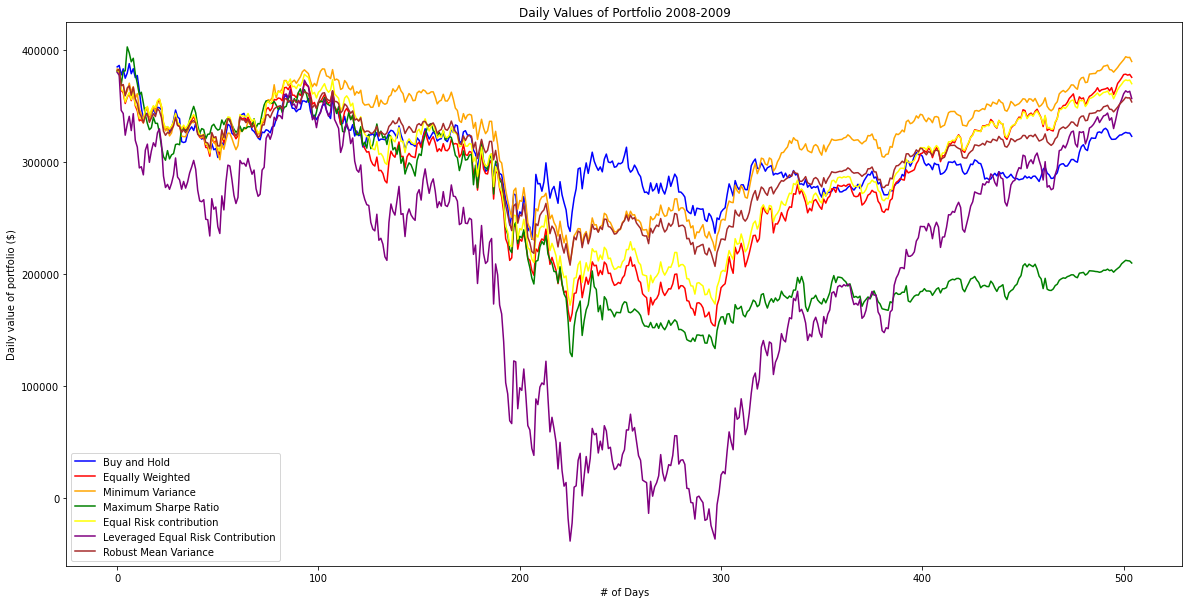

In [14]:
#Plot the daily value of the portfolio (for each trading strategy) over the years 2008 and 2009
plt.figure(figsize=(20,10))
plt.plot(portf_value[0], label='Buy and Hold', color='blue')
plt.plot(portf_value[1], label='Equally Weighted', color='red')
plt.plot(portf_value[2], label='Minimum Variance', color='orange')
plt.plot(portf_value[3], label='Maximum Sharpe Ratio', color='green')
plt.plot(portf_value[4],label='Equal Risk contribution', color = 'yellow')
plt.plot(portf_value[5],label='Leveraged Equal Risk Contribution', color = 'purple')
plt.plot(portf_value[6],label='Robust Mean Variance', color = 'brown')
plt.title('Daily Values of Portfolio 2008-2009')
plt.xlabel('# of Days')
plt.ylabel('Daily value of portfolio ($)')
plt.legend()
plt.show()


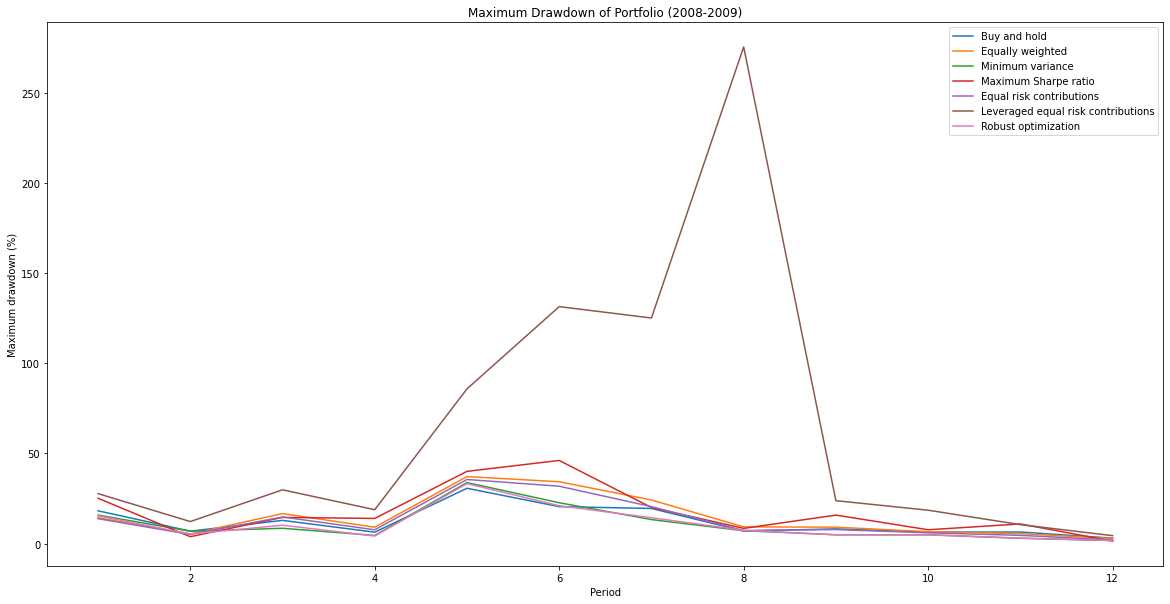

In [15]:
#Plot one chart in Python that illustrates maximum drawdown of your portfolio for each of the 12 periods
dfValues = pd.DataFrame()
for i in range(7):
    dfValues[str(i+1)] = portf_value[i].flatten()

dfList = []
indexArray = [[0,40],[41,82],[83,124],[125,167],[168,211],[212,252],[253,291],[292,334],[335,376],[377,419],[420,462],[463,504]]
for i in range(12):
    dfList.append(dfValues.loc[indexArray[i][0]:indexArray[i][1]])

maxDD_array = []
for i in range(12):
    periodArray = []
    for j in range(7):
        dfBuffer = ((dfList[i][str(j+1)] - dfList[i][str(j+1)].expanding().max()) / dfList[i][str(j+1)].expanding().max())*100
        dfBuffer = dfBuffer.abs()
        bufferVal = dfBuffer.max()
        periodArray.append(bufferVal)
    maxDD_array.append(periodArray)
    
dfMaxDD = pd.DataFrame()
for i in range(12):
    dfMaxDD[i+1] = maxDD_array[i] 
dfMaxDD = dfMaxDD.transpose()
dfMaxDD = dfMaxDD.rename(columns={0: "Buy and hold", 1: "Equally weighted", 2: "Minimum variance", 3: "Maximum Sharpe ratio", 4: "Equal risk contributions", 5: "Leveraged equal risk contributions", 6: "Robust optimization"})

dfMaxDD.plot(figsize=(20,10))
plt.title('Maximum Drawdown of Portfolio (2008-2009)')
plt.xlabel('Period')
plt.ylabel('Maximum drawdown (%)')
plt.show()

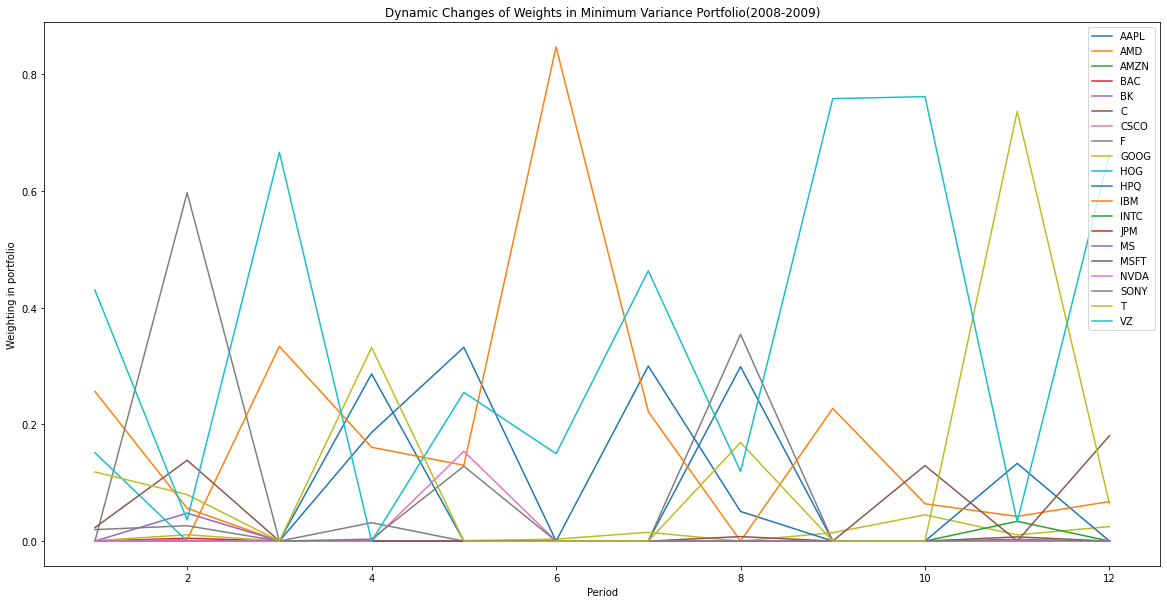

In [16]:
# Plot dynamic changes in portfolio allocations for strategy 3 Minimize Variance 
stocks = df.columns[1:]
w = []
for period in range(1, N_periods+1):
    w.append(x[2, period-1]/sum(x[2, period-1]))
df_minVar = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_minVar.plot(figsize=(20,10))
plt.title('Dynamic Changes of Weights in Minimum Variance Portfolio(2008-2009)')
plt.xlabel('Period')
plt.ylabel('Weighting in portfolio')
plt.show()

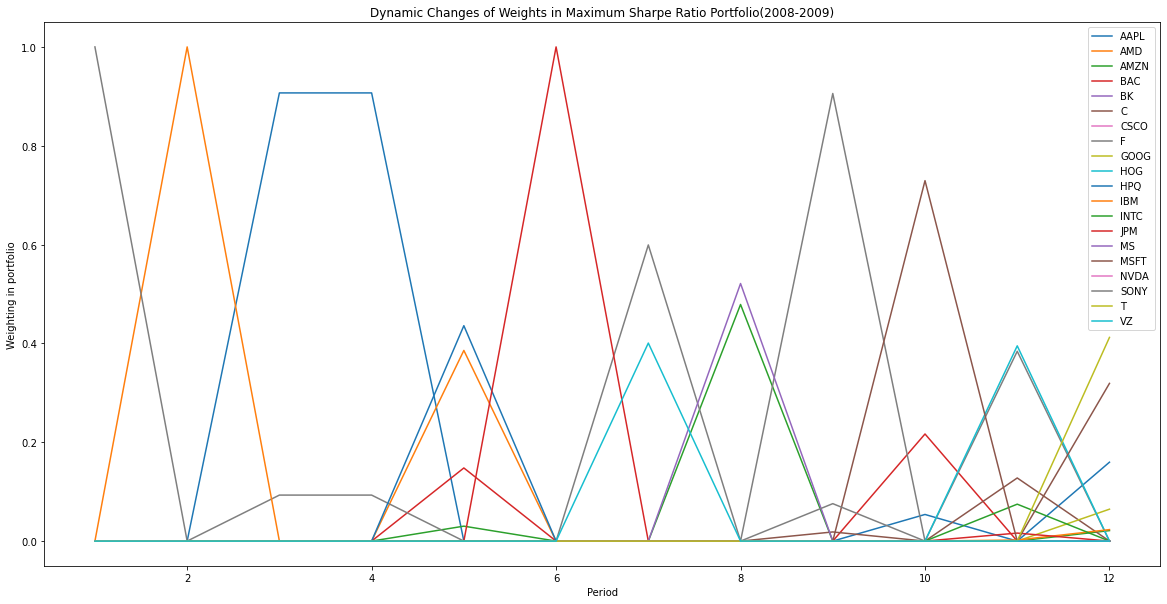

In [17]:
#Plot dynamic Changes in portfolio allocations for strategy 4 Maximize Sharpe Ratio 
stocks = df.columns[1:]
w = []
for period in range(1, N_periods+1):
    w.append(x[3, period-1]/sum(x[3, period-1]))
df_maxSR = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_maxSR.plot(figsize=(20,10))
plt.title('Dynamic Changes of Weights in Maximum Sharpe Ratio Portfolio(2008-2009)')
plt.xlabel('Period')
plt.ylabel('Weighting in portfolio')
plt.show()

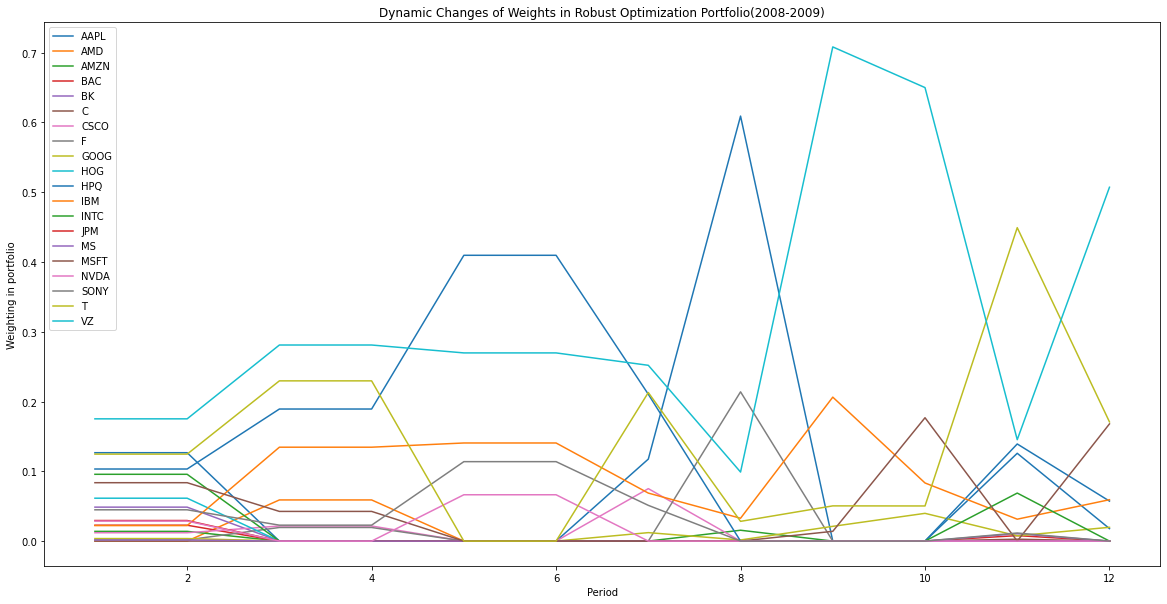

In [18]:
# Plot dynamic changes in portfolio allocations under strategy 7 Robust mean-variance optimization
stocks = df.columns[1:]
w = []
for period in range(1, N_periods+1):
    w.append(x[6, period-1]/sum(x[6, period-1]))
df_minVar = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_minVar.plot(figsize=(20,10))
plt.title('Dynamic Changes of Weights in Robust Optimization Portfolio(2008-2009)')
plt.xlabel('Period')
plt.ylabel('Weighting in portfolio')
plt.show()